# Capstone Project - Denver needs a new Wine Bar
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The objective of this project is to determine a location for a new business within the municipality of Denver, Colorado USA. This business will be a Wine Bar. It will feature a tasting menu as well as a variety of interesting wines from around the world. Wines will be available by the bottle, glass, or in flights.
Craft beer has been popular in Colorado for a long time, but wine is also popular. Many of the wine bars are outside of Denver in the surrounding suburbs. Over the past ten years or so there have been many, trendy neighborhoods that have been attracting more affluent millennials and others who enjoy living in a bustling urban area close to parks and quality restaurants.

The stakeholders want to capitalize on these trends and place a wine bar in one of these hot, trending neighborhoods. They would also consider a more established neighborhood with the correct demographics that is lacking a similar business.

## Data <a name="data"></a>

The data to be considered for this project will come from the following sources:
* A list of 25 distinct Denver Neighborhoods found in an article called The 25 Best Neighborhoods in Denver
* An article in the popular local magazine, 5280, called The 25 Best Neighborhoods in
Denver
* Data downloaded utilizing the Foursquare API including: most popular venues and
locations of wine bars
* Neighborhood Latitudes and Longitudes will be acquired using the Nominatim package
from geopy.geocoders.
* Google Maps was used to fill in missing or incorrect data as discovered in the initial exploratory analysis.

The data will be used to determine which of these neighborhoods already have wine bars, and which one would be favorable for the stakeholder's project. Popular venue lists from Foursqaure will be used gain an understanding on what these neighborhoods are like and what 

5280’s data comes from the Denver Police Department web page, American Community Survey’s 2013-2017 neighborhood data, and School Performance Framework. Their data was determined by using the following criteria quoted below from the article:

"Our ranking uses four variables: home prices, crime data, school rankings, and an X factor score that accounts for things that can’t be easily quantified, such as access to open space, nearby public transportation, and the prevalence of restaurants and shops. Each category is weighted: 30 percent for year-over-year percentage increase in home values; 25 percent for safety; 15 percent for neighborhood school ratings; and 30 percent for the X factor." 


This report will include maps of all of the Denver neighborhoods overlaid with the wine bar locations. It will use the venue data to find a location near other sit-down restaurants but not too close to any of the existing wine bars.

Kmeans clustering based on the top ten most popular venues for each neighborhood will be used to narrow down neighborhood candidates. 

The criteria for selecting a neighborhood for a new wine bar will include:

* Trending neighborhood - mandatory (all of them meet this criteria)
* Near a wine shop
* Not in a neighborhood with many fast food restaurants or discount stores - mandatory
* In a clulster that contains a neighborhood another wine bar - mandatory (clusters TBD in the Analysis section)
* In a neighborhood with other bars or breweries
* Doesn't already have a wine bar - mandatory
* Near a park

### Part 1 - Import and process the data

#### Install and load the necessary packages

In [497]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner



import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c anaconda beautifulsoup4 --yes #Package needed for the HTML web scraping
from bs4 import BeautifulSoup

import urllib.request

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /Users/katec/opt/anaconda3

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  conda                        anaconda::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /Users/katec/opt/anaconda3

  added / updated specs:
    - beautifulsoup4


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.8.3-py37hc8dfbb8~ --> anaconda::conda-4.8.3-py37_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Libraries imported.


#### Download and clean the neighborhood from the 5280 Best Denver Neighborhoods in 2020 article

In [498]:
url =  'https://www.5280.com/neighborhoods/'
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <title>
   The 25 Best Neighborhoods in Denver 2020
  </title>
  <!-- This site is optimized with the Yoast SEO Premium plugin v14.5 - https://yoast.com/wordpress/plugins/seo/ -->
  <meta content="We crunched the numbers to find the 25 best places to live in Denver now—plus what nearby eateries, shops, and more you can enjoy once you’re settled." name="description"/>
  <meta content="index, follow" name="robots"/>
  <meta content="index, follow, max-snippet:-1, max-image-preview:large, max-video-preview:-1" name="googlebot"/>
  <meta content="index, follow, max-snippet:-1, max-image-preview:large, max-video-preview:-1" name="bingbot"/>
  <link href="https://www.5280.com/neighborhoods/" rel="canonical"/>
  <meta content="en_US" property="og:locale"/>
  <meta content="article" property="og:type"/>
  <meta content="The 25 Best Neighborhoods in Denv

In [499]:
top_25=soup.find('table')
top_25

<table><thead><tr><th>Neighborhood</th><th>Rank</th><th>Population</th><th>2019 Average Sale Price</th><th>New Listings in 2019</th><th>Real Estate Rank</th><th>Schools Score</th><th>Crime Rank</th><th>X Factor Score</th></tr></thead><tfoot></tfoot><tbody><tr><td><a href="/neighborhood/south-park-hill">South Park Hill</a></td><td>1</td><td>9,491</td><td>$ 804,250</td><td>188</td><td>13</td><td>4.3</td><td>8</td><td>8.5</td></tr><tr><td><a href="/neighborhood/washington-park">Washington Park</a></td><td>2</td><td>7,400</td><td>$ 1,119,585</td><td>248</td><td>7</td><td>3</td><td>3</td><td>9</td></tr><tr><td><a href="/neighborhood/congress-park">Congress Park</a></td><td>3</td><td>11,559</td><td>$ 680,522</td><td>263</td><td>10</td><td>3.5</td><td>15</td><td>9</td></tr><tr><td><a href="/neighborhood/west-highland">West Highland</a></td><td>4</td><td>8,999</td><td>$ 661,257</td><td>310</td><td>11</td><td>3.5</td><td>25</td><td>8.5</td></tr><tr><td><a href="/neighborhood/cherry-creek">Cherr

In [500]:
Neighborhoods = []
Rank = []
AvgSalePrice2019 = []
CrimeRank = []
XFactorScore = []

for row in top_25.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)>3:
        Neighborhoods.append(cells[0].find(text=True))
        Rank.append(cells[1].find(text=True))
        AvgSalePrice2019.append(cells[3].find(text=True))
        CrimeRank.append(cells[7].find(text=True))
        XFactorScore.append(cells[8].find(text=True))
#We'll print the first few values to make sure we have the correct information
print("Neighborhoods:", Neighborhoods[0:3])
print("Rank:", Rank[0:3])
print("AvgSalePrice2019:", AvgSalePrice2019[0:3])
print("Crime Rank:", CrimeRank[0:3])
print("XFactorScore:", XFactorScore[0:3])

Neighborhoods: ['South Park Hill', 'Washington Park', 'Congress Park']
Rank: ['1', '2', '3']
AvgSalePrice2019: ['$ 804,250', '$ 1,119,585', '$ 680,522']
Crime Rank: ['8', '3', '15']
XFactorScore: ['8.5', '9', '9']


#### All we needed was the list of neighborhoods, but a few other columns were scraped to show some of the criteria used in the ranking.

In [501]:
top_25 = pd.DataFrame(Neighborhoods,columns=["Neighborhoods"])
top_25["Rank"] = Rank
top_25["AvgSalePrice2019"] = AvgSalePrice2019
top_25["CrimeRank"] = CrimeRank
top_25["XFactorScore"] = XFactorScore
top_25

,Neighborhoods,Rank,AvgSalePrice2019,CrimeRank,XFactorScore
0,South Park Hill,1,"$ 804,250",8,8.5
1,Washington Park,2,"$ 1,119,585",3,9
2,Congress Park,3,"$ 680,522",15,9
3,West Highland,4,"$ 661,257",25,8.5
4,Cherry Creek,5,"$ 1,165,333",52,8.5
5,Speer,6,"$ 505,815",44,8
6,Wellshire,7,"$ 812,084",1,7
7,Highland,8,"$ 700,576",51,9.5
8,Hilltop,9,"$ 983,055",4,8
9,University Hills,10,"$ 596,061",46,6.5


#### Append Denver, CO to each neighborhood in order to acquire the latitude and longitudes

In [502]:
addresses = []
for i in top_25['Neighborhoods']:
    address = i + ', Denver, CO'
    addresses.append(address)
len(addresses)

25

#### Acquire the neighborhood coordinates using the Novinatim API - create a list of all neighboorhoods that were not found

In [503]:
Latitudes = []
Longitudes = []
found = []
not_found = []
for address in addresses:
    try:
        geolocator = Nominatim(user_agent="denver_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        Latitudes.append(latitude)
        Longitudes.append(longitude)
        found.append(address)
    except AttributeError:
        not_found.append(address)
not_found

['Cory-Merrill, Denver, CO']

#### Create the data frame and append the missing neighborhoods with coordinates found on Google Maps

In [504]:
top25_data = pd.DataFrame(list(zip(found, Latitudes, Longitudes)),columns =['Neighborhood_address','Latitude','Longitude'])
print(top25_data.shape)
top25_data.head()

(24, 3)


,Neighborhood_address,Latitude,Longitude
0,"South Park Hill, Denver, CO",39.746650,-104.922043
1,"Washington Park, Denver, CO",39.702081,-104.971034
2,"Congress Park, Denver, CO",39.733720,-104.948367
3,"West Highland, Denver, CO",39.764466,-105.039271
4,"Cherry Creek, Denver, CO",39.663610,-104.877444


In [505]:
top25_data = top25_data.append({'Neighborhood_address' : 'Cory-Merrill, Denver, CO' , 'Latitude' : 39.689842, 'Longitude' : -104.958810} , ignore_index=True)
print(top25_data.shape)
top25_data

(25, 3)


,Neighborhood_address,Latitude,Longitude
0,"South Park Hill, Denver, CO",39.746650,-104.922043
1,"Washington Park, Denver, CO",39.702081,-104.971034
2,"Congress Park, Denver, CO",39.733720,-104.948367
3,"West Highland, Denver, CO",39.764466,-105.039271
4,"Cherry Creek, Denver, CO",39.663610,-104.877444
5,"Speer, Denver, CO",39.756877,-105.018439
6,"Wellshire, Denver, CO",39.660530,-104.950091
7,"Highland, Denver, CO",39.761583,-105.012500
8,"Hilltop, Denver, CO",39.783079,-104.993961
9,"University Hills, Denver, CO",39.666944,-104.938412


#### Denver neighborhoods are changing rapidly. Verify that the Novinatim API identified unique neighborhoods and did not lump any together

In [506]:
top25_data['Longitude'].value_counts().head()

-104.971034    2
-104.931128    1
-104.977986    1
-105.043968    1
-87.899960     1
Name: Longitude, dtype: int64

In [507]:
top25_data['Latitude'].value_counts().head()

39.702081    2
39.775231    1
39.686780    1
39.754658    1
39.752426    1
Name: Latitude, dtype: int64

#### The Novinatim API has the same coordinates for Washington Park and Washington Park West. 
The correct coordinates will be updated with data from Google Maps

In [508]:
top25_data.replace({'Latitude': {1: 39.697937 , 13: 39.7005822}})
top25_data.replace({'Longitude': {1: -104.975186 , 13: -104.9980279}})
top25_data

,Neighborhood_address,Latitude,Longitude
0,"South Park Hill, Denver, CO",39.746650,-104.922043
1,"Washington Park, Denver, CO",39.702081,-104.971034
2,"Congress Park, Denver, CO",39.733720,-104.948367
3,"West Highland, Denver, CO",39.764466,-105.039271
4,"Cherry Creek, Denver, CO",39.663610,-104.877444
5,"Speer, Denver, CO",39.756877,-105.018439
6,"Wellshire, Denver, CO",39.660530,-104.950091
7,"Highland, Denver, CO",39.761583,-105.012500
8,"Hilltop, Denver, CO",39.783079,-104.993961
9,"University Hills, Denver, CO",39.666944,-104.938412


#### Create a map of the neighborhoods using the folium package

In [509]:
map_top25_denver = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(top25_data['Latitude'], top25_data['Longitude'], top25_data['Neighborhood_address']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#0000FF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_top25_denver)  
    
map_top25_denver

## Methodology <a name="methodology"></a>

For this project we are going too need to determine what kind of venues are popular in each neighborhood. Acquiring a Foursquare developer account is mandatory for this project. The advantages of using the Foursquare API is that it has generous API call limits for the free version. Once the Foursquare account is set up and credentials are established for Client ID and Client Secret, then the venue data can be acquired.

Once the venue data has been acquired and processed into a data frame, then a separate data frame can be created with only Wine Bars.

The Neighborhoods will be mapped with an overlay of the existing wine bars to get a better idea as to where they sit among the various neighborhoods.

The neighborhood and venue data will then be processed so that we can perform Kmeans clustering to group the neighborhoods into clusters based on their most popular venues.

The next step will be to select all of the clusters with existing wine bars and combine them into one data frame. If the cluster contains at least 15 neighborhoods then we will re-cluster the data using Kmeans to narrow down the choices.

Finally, we will revisit the selection criteria highlighted in the Data section and make a final selection.

## Analysis <a name="analysis"></a>

### Part 2 - Acquire the nearby venues for these neighborhoods

In [510]:
LIMIT = 500
CLIENT_ID = 'W0R2GFLMDRISEMFDMQKT4GBTC2YI1X05ZC4JS4M5HKVTKCRN' # your Foursquare ID
CLIENT_SECRET = '0QKQFRBINAS5VZML13XAFWOAJAF413QS2DQADRYQESQFKP3B' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W0R2GFLMDRISEMFDMQKT4GBTC2YI1X05ZC4JS4M5HKVTKCRN
CLIENT_SECRET:0QKQFRBINAS5VZML13XAFWOAJAF413QS2DQADRYQESQFKP3B


In [511]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [512]:
top25_denver_venues = getNearbyVenues(names=top25_data['Neighborhood_address'],
                                   latitudes=top25_data['Latitude'],
                                   longitudes=top25_data['Longitude']
                                  )

South Park Hill, Denver, CO
Washington Park, Denver, CO
Congress Park, Denver, CO
West Highland, Denver, CO
Cherry Creek, Denver, CO
Speer, Denver, CO
Wellshire, Denver, CO
Highland, Denver, CO
Hilltop, Denver, CO
University Hills, Denver, CO
Berkeley, Denver, CO
Union Station, Denver, CO
Indian Creek, Denver, CO
Washington Park West, Denver, CO
Five Points, Denver, CO
Hale, Denver, CO
Platt Park, Denver, CO
Southmoor Park, Denver, CO
Regis, Denver, CO
Country Club, Denver, CO
Barnum West, Denver, CO
Central Business District, Denver, CO
Skyland, Denver, CO
Sloan Lake, Denver, CO
Cory-Merrill, Denver, CO


In [513]:
print(top25_denver_venues.shape)
top25_denver_venues.head()

(1388, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"South Park Hill, Denver, CO",39.74665,-104.922043,Tables,39.750467,-104.917752,American Restaurant
1,"South Park Hill, Denver, CO",39.74665,-104.922043,Oblio's Pizza,39.749372,-104.917054,Pizza Place
2,"South Park Hill, Denver, CO",39.74665,-104.922043,Neighbors,39.749480,-104.917345,Tapas Restaurant
3,"South Park Hill, Denver, CO",39.74665,-104.922043,Grape Expectations,39.750530,-104.917398,Wine Shop
4,"South Park Hill, Denver, CO",39.74665,-104.922043,Cake Crumbs,39.749740,-104.917365,Bakery


In [514]:
top25_denver_venues['Venue Category'].value_counts()

Coffee Shop                        69
American Restaurant                53
Bar                                48
Mexican Restaurant                 46
Pizza Place                        45
Brewery                            39
Park                               34
Italian Restaurant                 33
Zoo Exhibit                        25
Cocktail Bar                       24
Sandwich Place                     24
Ice Cream Shop                     23
Sushi Restaurant                   23
Bakery                             22
Hotel                              21
Yoga Studio                        21
Breakfast Spot                     20
Café                               18
Burger Joint                       17
Gym                                16
Marijuana Dispensary               16
Grocery Store                      15
New American Restaurant            15
Convenience Store                  14
Fast Food Restaurant               14
Gym / Fitness Center               14
Restaurant  

### Part 3 - Find the wine bars in these neighborhoods

In [515]:
wine_bars = top25_denver_venues[top25_denver_venues['Venue Category'] == 'Wine Bar']
wine_bars

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
290,"Speer, Denver, CO",39.756877,-105.018439,The Truffle Table,39.758129,-105.011643,Wine Bar
413,"Highland, Denver, CO",39.761583,-105.012500,The Truffle Table,39.758129,-105.011643,Wine Bar
590,"Berkeley, Denver, CO",39.775231,-105.039261,BookBar,39.775213,-105.043888,Wine Bar
740,"Union Station, Denver, CO",39.753630,-105.000748,Cru Wine Bar,39.747963,-104.998908,Wine Bar
910,"Five Points, Denver, CO",39.754658,-104.977986,Mile High Winery,39.761417,-104.983637,Wine Bar
1239,"Central Business District, Denver, CO",39.747378,-104.992737,Cru Wine Bar,39.747963,-104.998908,Wine Bar


#### There is a mistake on Foursquare. The Truffle Table, listed twice, is actually in the Highland neighborhood, not Speer. Removing that row.

In [517]:
wine_bars = wine_bars.drop(index=290)
wine_bars

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
413,"Highland, Denver, CO",39.761583,-105.012500,The Truffle Table,39.758129,-105.011643,Wine Bar
590,"Berkeley, Denver, CO",39.775231,-105.039261,BookBar,39.775213,-105.043888,Wine Bar
740,"Union Station, Denver, CO",39.753630,-105.000748,Cru Wine Bar,39.747963,-104.998908,Wine Bar
910,"Five Points, Denver, CO",39.754658,-104.977986,Mile High Winery,39.761417,-104.983637,Wine Bar
1239,"Central Business District, Denver, CO",39.747378,-104.992737,Cru Wine Bar,39.747963,-104.998908,Wine Bar


In [518]:
map_winebars_overlay = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(top25_data['Latitude'], top25_data['Longitude'], top25_data['Neighborhood_address']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#0000FF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_winebars_overlay)

for lat, lng, neighborhood in zip(wine_bars['Venue Latitude'], wine_bars['Venue Longitude'], wine_bars['Venue']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#fafad2',
        fill_opacity=0.5,
        parse_html=False).add_to(map_winebars_overlay)
    
    
map_winebars_overlay

### Part 4 - Preprocess and perform kmeans clustering on the neighborhood data

In [519]:
top25_denver_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Barnum West, Denver, CO",16,16,16,16,16,16
"Berkeley, Denver, CO",88,88,88,88,88,88
"Central Business District, Denver, CO",100,100,100,100,100,100
"Cherry Creek, Denver, CO",6,6,6,6,6,6
"Congress Park, Denver, CO",83,83,83,83,83,83
"Cory-Merrill, Denver, CO",32,32,32,32,32,32
"Country Club, Denver, CO",6,6,6,6,6,6
"Five Points, Denver, CO",100,100,100,100,100,100
"Hale, Denver, CO",64,64,64,64,64,64


In [520]:
# one hot encoding
denver_onehot = pd.get_dummies(top25_denver_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
denver_onehot['Neighborhood'] = top25_denver_venues['Neighborhood'] 

# move neighborhood column to the first column
col_name="Neighborhood"
first_col = denver_onehot.pop(col_name)
denver_onehot.insert(0, col_name, first_col)

denver_onehot.head()

,Neighborhood,ATM,Accessories Store,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cheese Shop,Chinese Restaurant,Chiropractor,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,New American Restaurant,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Recreation Center,Recycling Facility,Rental Car Location,Restaurant,River,Rock Club,Roof Deck,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"South Park Hill, Denver, CO",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"South Park Hill, Denver, CO",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [521]:
denver_onehot.shape

(1388, 240)

In [522]:
denver_grouped = denver_onehot.groupby('Neighborhood').mean().reset_index()
denver_grouped.shape

(25, 240)

In [523]:
num_top_venues = 5

for hood in denver_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = denver_grouped[denver_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barnum West, Denver, CO----
                 venue  freq
0    Mobile Phone Shop  0.12
1    Convenience Store  0.12
2  American Restaurant  0.12
3       Discount Store  0.12
4   Mexican Restaurant  0.12


----Berkeley, Denver, CO----
                venue  freq
0         Coffee Shop  0.07
1         Pizza Place  0.06
2             Brewery  0.06
3  Mexican Restaurant  0.05
4                Park  0.05


----Central Business District, Denver, CO----
                 venue  freq
0                Hotel  0.13
1  American Restaurant  0.08
2          Coffee Shop  0.05
3   Italian Restaurant  0.04
4           Restaurant  0.04


----Cherry Creek, Denver, CO----
             venue  freq
0             Park  0.33
1         Dive Bar  0.17
2  Automotive Shop  0.17
3            Trail  0.17
4              Gym  0.17


----Congress Park, Denver, CO----
                  venue  freq
0           Coffee Shop  0.07
1           Pizza Place  0.06
2                   Bar  0.06
3      Greek Restaurant  0.05
4 

In [524]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [525]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = denver_grouped['Neighborhood']

for ind in np.arange(denver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(denver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Barnum West, Denver, CO",Convenience Store,Mobile Phone Shop,American Restaurant,Discount Store,Mexican Restaurant,Coffee Shop,Bar,Fast Food Restaurant,Home Service,Grocery Store
1,"Berkeley, Denver, CO",Coffee Shop,Pizza Place,Brewery,Park,Mexican Restaurant,Breakfast Spot,Italian Restaurant,American Restaurant,Gym / Fitness Center,Bakery
2,"Central Business District, Denver, CO",Hotel,American Restaurant,Coffee Shop,Lounge,Italian Restaurant,Steakhouse,Restaurant,Theater,Cocktail Bar,Sandwich Place
3,"Cherry Creek, Denver, CO",Park,Gym,Dive Bar,Trail,Automotive Shop,Exhibit,Event Space,Ethiopian Restaurant,Electronics Store,Dessert Shop
4,"Congress Park, Denver, CO",Coffee Shop,Pizza Place,Bar,Greek Restaurant,Grocery Store,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Convenience Store,Burger Joint
5,"Cory-Merrill, Denver, CO",Breakfast Spot,Park,American Restaurant,Athletics & Sports,Italian Restaurant,Eye Doctor,Tennis Court,Basketball Court,Taco Place,Stadium
6,"Country Club, Denver, CO",Pool,Golf Course,Beach,Park,Furniture / Home Store,Pub,Concert Hall,Diner,Eye Doctor,Exhibit
7,"Five Points, Denver, CO",Brewery,Bar,Coffee Shop,Mexican Restaurant,Rock Club,Marijuana Dispensary,Cocktail Bar,Burger Joint,Café,Bakery
8,"Hale, Denver, CO",Pizza Place,Sandwich Place,Bar,Coffee Shop,Pharmacy,Smoke Shop,Mexican Restaurant,Donut Shop,Thai Restaurant,Ice Cream Shop
9,"Highland, Denver, CO",Coffee Shop,Cocktail Bar,Café,Italian Restaurant,Park,American Restaurant,Brewery,Bar,Pizza Place,Mexican Restaurant


In [526]:
neighborhoods_venues_sorted.shape

(25, 11)

#### Create the dataset for the Kmeans. Loop through 25 times to create the elbow graph to select the optimum number of clusters

In [527]:
X = denver_grouped.drop('Neighborhood', 1)

In [528]:
wcss = []
for i in range(1,25):
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=600,  n_init=25,random_state=0 )
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

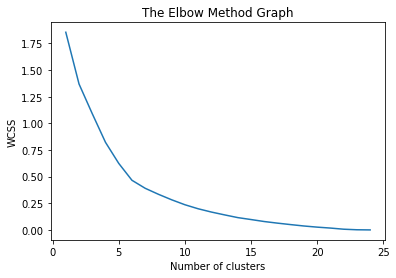

In [529]:
import matplotlib.pyplot as plt
plt.plot(range(1,25),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### There is a bend in the elbow graph just past 5 so we will use 6 clusters.

In [530]:
kmeans = KMeans(n_clusters=6, init ='k-means++', max_iter=300, n_init=6,random_state=0 )
y_kmeans = kmeans.fit_predict(X)
kmeans.labels_[0:10] 

array([0, 0, 0, 5, 0, 0, 3, 0, 0, 0], dtype=int32)

#### Insert the cluster labels into the combined neighborhood and top ten venue data frame.

In [531]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

top25_denver_merged = top25_data

top25_denver_merged = top25_denver_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood_address')

top25_denver_merged.head() # check the columns!

,Neighborhood_address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"South Park Hill, Denver, CO",39.746650,-104.922043,0,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Gym / Fitness Center,Marijuana Dispensary,American Restaurant,Ethiopian Restaurant,Discount Store,Bus Stop,Smoke Shop
1,"Washington Park, Denver, CO",39.702081,-104.971034,0,Coffee Shop,American Restaurant,Gift Shop,Lake,Boutique,Park,Spa,Bike Rental / Bike Share,Italian Restaurant,Ice Cream Shop
2,"Congress Park, Denver, CO",39.733720,-104.948367,0,Coffee Shop,Pizza Place,Bar,Greek Restaurant,Grocery Store,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Convenience Store,Burger Joint
3,"West Highland, Denver, CO",39.764466,-105.039271,0,Coffee Shop,Pizza Place,Bar,Mexican Restaurant,Sushi Restaurant,American Restaurant,Liquor Store,Fast Food Restaurant,Brewery,Gym / Fitness Center
4,"Cherry Creek, Denver, CO",39.663610,-104.877444,5,Park,Gym,Dive Bar,Trail,Automotive Shop,Exhibit,Event Space,Ethiopian Restaurant,Electronics Store,Dessert Shop


### Part 5 - Analize the clusters and select which ones to explore further

#### Visualize the cluster locations using Folium

In [554]:
# create map
kclusters = 6
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, clust in zip(top25_denver_merged['Latitude'], top25_denver_merged['Longitude'], top25_denver_merged['Neighborhood_address'], top25_denver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(clust), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[clust-1],
        fill=True,
        fill_color=rainbow[clust-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Slice the final data frame containing the clusert labels into each separate cluster and examine each one. 

In [533]:
top25_denver_merged.loc[top25_denver_merged['Cluster Labels'] == 0,top25_denver_merged.columns[[0] + list(range(3, top25_denver_merged.shape[1]))]]

,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"South Park Hill, Denver, CO",0,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Gym / Fitness Center,Marijuana Dispensary,American Restaurant,Ethiopian Restaurant,Discount Store,Bus Stop,Smoke Shop
1,"Washington Park, Denver, CO",0,Coffee Shop,American Restaurant,Gift Shop,Lake,Boutique,Park,Spa,Bike Rental / Bike Share,Italian Restaurant,Ice Cream Shop
2,"Congress Park, Denver, CO",0,Coffee Shop,Pizza Place,Bar,Greek Restaurant,Grocery Store,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Convenience Store,Burger Joint
3,"West Highland, Denver, CO",0,Coffee Shop,Pizza Place,Bar,Mexican Restaurant,Sushi Restaurant,American Restaurant,Liquor Store,Fast Food Restaurant,Brewery,Gym / Fitness Center
5,"Speer, Denver, CO",0,Coffee Shop,Mexican Restaurant,Café,Cocktail Bar,Bar,Brewery,Italian Restaurant,Sushi Restaurant,Park,Pizza Place
7,"Highland, Denver, CO",0,Coffee Shop,Cocktail Bar,Café,Italian Restaurant,Park,American Restaurant,Brewery,Bar,Pizza Place,Mexican Restaurant
8,"Hilltop, Denver, CO",0,Intersection,Brewery,Liquor Store,Dive Bar,Building,Restaurant,Rental Car Location,Steakhouse,Furniture / Home Store,Automotive Shop
9,"University Hills, Denver, CO",0,Pharmacy,Hookah Bar,Bank,Sandwich Place,Middle Eastern Restaurant,Coffee Shop,Department Store,Gym / Fitness Center,Grocery Store,Pizza Place
10,"Berkeley, Denver, CO",0,Coffee Shop,Pizza Place,Brewery,Park,Mexican Restaurant,Breakfast Spot,Italian Restaurant,American Restaurant,Gym / Fitness Center,Bakery
11,"Union Station, Denver, CO",0,American Restaurant,Cocktail Bar,Hotel,Mexican Restaurant,Gym,Park,New American Restaurant,Seafood Restaurant,Lounge,Bar


In [534]:
top25_denver_merged.loc[top25_denver_merged['Cluster Labels'] == 1,top25_denver_merged.columns[[0] + list(range(3, top25_denver_merged.shape[1]))]]

,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Indian Creek, Denver, CO",1,Gym / Fitness Center,River,Zoo Exhibit,Dessert Shop,Farmers Market,Eye Doctor,Exhibit,Event Space,Ethiopian Restaurant,Electronics Store


In [535]:
top25_denver_merged.loc[top25_denver_merged['Cluster Labels'] == 2,top25_denver_merged.columns[[0] + list(range(3, top25_denver_merged.shape[1]))]]

,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Wellshire, Denver, CO",2,Golf Course,Pharmacy,Bus Stop,Arcade,Zoo Exhibit,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Ethiopian Restaurant


In [536]:
top25_denver_merged.loc[top25_denver_merged['Cluster Labels'] == 3,top25_denver_merged.columns[[0] + list(range(3, top25_denver_merged.shape[1]))]]

,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,"Country Club, Denver, CO",3,Pool,Golf Course,Beach,Park,Furniture / Home Store,Pub,Concert Hall,Diner,Eye Doctor,Exhibit


In [537]:
top25_denver_merged.loc[top25_denver_merged['Cluster Labels'] == 4,top25_denver_merged.columns[[0] + list(range(3, top25_denver_merged.shape[1]))]]

,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,"Skyland, Denver, CO",4,Zoo Exhibit,Exhibit,Fast Food Restaurant,Liquor Store,French Restaurant,Southern / Soul Food Restaurant,Lake,Discount Store,Baseball Field,Tennis Court


In [538]:
top25_denver_merged.loc[top25_denver_merged['Cluster Labels'] == 5,top25_denver_merged.columns[[0] + list(range(3, top25_denver_merged.shape[1]))]]

,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Cherry Creek, Denver, CO",5,Park,Gym,Dive Bar,Trail,Automotive Shop,Exhibit,Event Space,Ethiopian Restaurant,Electronics Store,Dessert Shop


#### The first cluster containes twenty venues so these will be re-clustered using Kmeans

In [539]:
cluster1 = top25_denver_merged.loc[top25_denver_merged['Cluster Labels'] == 0]
cluster1

,Neighborhood_address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"South Park Hill, Denver, CO",39.746650,-104.922043,0,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Gym / Fitness Center,Marijuana Dispensary,American Restaurant,Ethiopian Restaurant,Discount Store,Bus Stop,Smoke Shop
1,"Washington Park, Denver, CO",39.702081,-104.971034,0,Coffee Shop,American Restaurant,Gift Shop,Lake,Boutique,Park,Spa,Bike Rental / Bike Share,Italian Restaurant,Ice Cream Shop
2,"Congress Park, Denver, CO",39.733720,-104.948367,0,Coffee Shop,Pizza Place,Bar,Greek Restaurant,Grocery Store,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Convenience Store,Burger Joint
3,"West Highland, Denver, CO",39.764466,-105.039271,0,Coffee Shop,Pizza Place,Bar,Mexican Restaurant,Sushi Restaurant,American Restaurant,Liquor Store,Fast Food Restaurant,Brewery,Gym / Fitness Center
5,"Speer, Denver, CO",39.756877,-105.018439,0,Coffee Shop,Mexican Restaurant,Café,Cocktail Bar,Bar,Brewery,Italian Restaurant,Sushi Restaurant,Park,Pizza Place
7,"Highland, Denver, CO",39.761583,-105.012500,0,Coffee Shop,Cocktail Bar,Café,Italian Restaurant,Park,American Restaurant,Brewery,Bar,Pizza Place,Mexican Restaurant
8,"Hilltop, Denver, CO",39.783079,-104.993961,0,Intersection,Brewery,Liquor Store,Dive Bar,Building,Restaurant,Rental Car Location,Steakhouse,Furniture / Home Store,Automotive Shop
9,"University Hills, Denver, CO",39.666944,-104.938412,0,Pharmacy,Hookah Bar,Bank,Sandwich Place,Middle Eastern Restaurant,Coffee Shop,Department Store,Gym / Fitness Center,Grocery Store,Pizza Place
10,"Berkeley, Denver, CO",39.775231,-105.039261,0,Coffee Shop,Pizza Place,Brewery,Park,Mexican Restaurant,Breakfast Spot,Italian Restaurant,American Restaurant,Gym / Fitness Center,Bakery
11,"Union Station, Denver, CO",39.753630,-105.000748,0,American Restaurant,Cocktail Bar,Hotel,Mexican Restaurant,Gym,Park,New American Restaurant,Seafood Restaurant,Lounge,Bar


In [540]:
cluster1.shape

(20, 14)

#### Visualize this cluster on the map using Folium. Include an overlay of the wine bars

In [541]:
map_winebars_cluster1 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(cluster1['Latitude'], cluster1['Longitude'], cluster1['Neighborhood_address']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#0000FF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_winebars_cluster1)

for lat, lng, neighborhood in zip(wine_bars['Venue Latitude'], wine_bars['Venue Longitude'], wine_bars['Venue']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#fafad2',
        fill_opacity=0.5,
        parse_html=False).add_to(map_winebars_cluster1)
    
    
map_winebars_cluster1

### Part 6 - Preprocess and perform kmeans clustering on the selected cluster from part 5
This is the cluster containing the neighborhoods with all of the existing wine bars

In [542]:
cluster1_neighborhoods = cluster1['Neighborhood_address']
cluster1_grouped = denver_grouped[denver_grouped['Neighborhood'].isin(cluster1_neighborhoods)]
cluster1_grouped.head()

,Neighborhood,ATM,Accessories Store,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cheese Shop,Chinese Restaurant,Chiropractor,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,New American Restaurant,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Recreation Center,Recycling Facility,Rental Car Location,Restaurant,River,Rock Club,Roof Deck,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Barnum West, Denver, CO",0.000000,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.062500,0.0,0.0,0.00000,0.0,0.0,0.0,0.00,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.062500,0.00,0.0,0.00,0.0,0.125000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.125,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.062500,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,

#### Re-do the Kmeans steps to cluster this subset of the data

In [543]:
X_2 = cluster1_grouped.drop('Neighborhood', 1)
X_2.shape

(20, 239)

In [544]:
wcss2 = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=20,random_state=0 )
    kmeans.fit(X_2)
    wcss2.append(kmeans.inertia_)

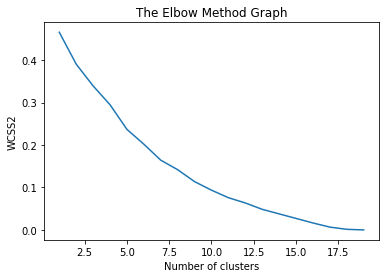

In [545]:
import matplotlib.pyplot as plt
plt.plot(range(1,20),wcss2)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS2')
plt.show()

#### This graph is not terribly clear but there is a tiny bend at 5, so 5 clusters will be used.

In [546]:
kmeans2 = KMeans(n_clusters=5, init ='k-means++', max_iter=300, n_init=5,random_state=0 )
y_kmeans2 = kmeans2.fit_predict(X_2)
kmeans2.labels_[0:10] 

array([3, 2, 2, 2, 4, 2, 1, 2, 2, 2], dtype=int32)

#### Add the cluster labels to the cluster1 data frame

In [547]:
# add clustering labels

cluster1_new = cluster1.drop(['Cluster Labels'],axis=1)
cluster1_new.insert(3, 'Cluster Labels', kmeans2.labels_)

cluster1_new.head(10) # check the columns!

,Neighborhood_address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"South Park Hill, Denver, CO",39.746650,-104.922043,3,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Gym / Fitness Center,Marijuana Dispensary,American Restaurant,Ethiopian Restaurant,Discount Store,Bus Stop,Smoke Shop
1,"Washington Park, Denver, CO",39.702081,-104.971034,2,Coffee Shop,American Restaurant,Gift Shop,Lake,Boutique,Park,Spa,Bike Rental / Bike Share,Italian Restaurant,Ice Cream Shop
2,"Congress Park, Denver, CO",39.733720,-104.948367,2,Coffee Shop,Pizza Place,Bar,Greek Restaurant,Grocery Store,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Convenience Store,Burger Joint
3,"West Highland, Denver, CO",39.764466,-105.039271,2,Coffee Shop,Pizza Place,Bar,Mexican Restaurant,Sushi Restaurant,American Restaurant,Liquor Store,Fast Food Restaurant,Brewery,Gym / Fitness Center
5,"Speer, Denver, CO",39.756877,-105.018439,4,Coffee Shop,Mexican Restaurant,Café,Cocktail Bar,Bar,Brewery,Italian Restaurant,Sushi Restaurant,Park,Pizza Place
7,"Highland, Denver, CO",39.761583,-105.012500,2,Coffee Shop,Cocktail Bar,Café,Italian Restaurant,Park,American Restaurant,Brewery,Bar,Pizza Place,Mexican Restaurant
8,"Hilltop, Denver, CO",39.783079,-104.993961,1,Intersection,Brewery,Liquor Store,Dive Bar,Building,Restaurant,Rental Car Location,Steakhouse,Furniture / Home Store,Automotive Shop
9,"University Hills, Denver, CO",39.666944,-104.938412,2,Pharmacy,Hookah Bar,Bank,Sandwich Place,Middle Eastern Restaurant,Coffee Shop,Department Store,Gym / Fitness Center,Grocery Store,Pizza Place
10,"Berkeley, Denver, CO",39.775231,-105.039261,2,Coffee Shop,Pizza Place,Brewery,Park,Mexican Restaurant,Breakfast Spot,Italian Restaurant,American Restaurant,Gym / Fitness Center,Bakery
11,"Union Station, Denver, CO",39.753630,-105.000748,2,American Restaurant,Cocktail Bar,Hotel,Mexican Restaurant,Gym,Park,New American Restaurant,Seafood Restaurant,Lounge,Bar


#### Map the final clusters with an overlay of the wine bars.

In [548]:
# create map
kclusters = 5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, clust in zip(cluster1_new['Latitude'], cluster1_new['Longitude'], cluster1_new['Neighborhood_address'], top25_denver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(clust), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[clust-1],
        fill=True,
        fill_color=rainbow[clust-1],
        fill_opacity=0.7).add_to(map_clusters)
for lat, lng, neighborhood in zip(wine_bars['Venue Latitude'], wine_bars['Venue Longitude'], wine_bars['Venue']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#fafad2',
        fill_opacity=0.5,
        parse_html=False).add_to(map_clusters)
       
map_clusters

#### Slice the data frame by cluster and analyzise them to narrow down our neighborhood choices

In [549]:
cluster1_new.loc[cluster1_new['Cluster Labels'] == 0,cluster1_new.columns[[0] + list(range(3, cluster1_new.shape[1]))]]


,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Five Points, Denver, CO",0,Brewery,Bar,Coffee Shop,Mexican Restaurant,Rock Club,Marijuana Dispensary,Cocktail Bar,Burger Joint,Café,Bakery


In [550]:
cluster1_new.loc[cluster1_new['Cluster Labels'] == 1,cluster1_new.columns[[0] + list(range(3, cluster1_new.shape[1]))]]


,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Hilltop, Denver, CO",1,Intersection,Brewery,Liquor Store,Dive Bar,Building,Restaurant,Rental Car Location,Steakhouse,Furniture / Home Store,Automotive Shop
15,"Hale, Denver, CO",1,Pizza Place,Sandwich Place,Bar,Coffee Shop,Pharmacy,Smoke Shop,Mexican Restaurant,Donut Shop,Thai Restaurant,Ice Cream Shop
20,"Barnum West, Denver, CO",1,Convenience Store,Mobile Phone Shop,American Restaurant,Discount Store,Mexican Restaurant,Coffee Shop,Bar,Fast Food Restaurant,Home Service,Grocery Store


In [551]:
cluster1_new.loc[cluster1_new['Cluster Labels'] == 2,cluster1_new.columns[[0] + list(range(3, cluster1_new.shape[1]))]]


,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Washington Park, Denver, CO",2,Coffee Shop,American Restaurant,Gift Shop,Lake,Boutique,Park,Spa,Bike Rental / Bike Share,Italian Restaurant,Ice Cream Shop
2,"Congress Park, Denver, CO",2,Coffee Shop,Pizza Place,Bar,Greek Restaurant,Grocery Store,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Convenience Store,Burger Joint
3,"West Highland, Denver, CO",2,Coffee Shop,Pizza Place,Bar,Mexican Restaurant,Sushi Restaurant,American Restaurant,Liquor Store,Fast Food Restaurant,Brewery,Gym / Fitness Center
7,"Highland, Denver, CO",2,Coffee Shop,Cocktail Bar,Café,Italian Restaurant,Park,American Restaurant,Brewery,Bar,Pizza Place,Mexican Restaurant
9,"University Hills, Denver, CO",2,Pharmacy,Hookah Bar,Bank,Sandwich Place,Middle Eastern Restaurant,Coffee Shop,Department Store,Gym / Fitness Center,Grocery Store,Pizza Place
10,"Berkeley, Denver, CO",2,Coffee Shop,Pizza Place,Brewery,Park,Mexican Restaurant,Breakfast Spot,Italian Restaurant,American Restaurant,Gym / Fitness Center,Bakery
11,"Union Station, Denver, CO",2,American Restaurant,Cocktail Bar,Hotel,Mexican Restaurant,Gym,Park,New American Restaurant,Seafood Restaurant,Lounge,Bar
13,"Washington Park West, Denver, CO",2,Coffee Shop,American Restaurant,Gift Shop,Lake,Boutique,Park,Spa,Bike Rental / Bike Share,Italian Restaurant,Ice Cream Shop
16,"Platt Park, Denver, CO",2,Bar,Marijuana Dispensary,Brewery,Mexican Restaurant,Yoga Studio,American Restaurant,Coffee Shop,Garden Center,Bakery,Thrift / Vintage Store
17,"Southmoor Park, Denver, CO",2,Mexican Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Japanese Restaurant,Mediterranean Restaurant,Deli / Bodega,Shipping Store,Park,Grocery Store


In [552]:
cluster1_new.loc[cluster1_new['Cluster Labels'] == 3,cluster1_new.columns[[0] + list(range(3, cluster1_new.shape[1]))]]


,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"South Park Hill, Denver, CO",3,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Gym / Fitness Center,Marijuana Dispensary,American Restaurant,Ethiopian Restaurant,Discount Store,Bus Stop,Smoke Shop


In [553]:
cluster1_new.loc[cluster1_new['Cluster Labels'] == 4,cluster1_new.columns[[0] + list(range(3, cluster1_new.shape[1]))]]


,Neighborhood_address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Speer, Denver, CO",4,Coffee Shop,Mexican Restaurant,Café,Cocktail Bar,Bar,Brewery,Italian Restaurant,Sushi Restaurant,Park,Pizza Place
21,"Central Business District, Denver, CO",4,Hotel,American Restaurant,Coffee Shop,Lounge,Italian Restaurant,Steakhouse,Restaurant,Theater,Cocktail Bar,Sandwich Place
23,"Sloan Lake, Denver, CO",4,Park,Coffee Shop,Art Gallery,Brewery,Moving Target,Bar,Tennis Court,Dessert Shop,Bagel Shop,Garden Center


## Results and Discussion <a name="results"></a>

#### Narrowing down the potential neighborhoods
This new Wine Bar should be located in a neighborhood in the following criteria as mentioned in the data section:
* Trending neighborhood - mandatory (all of them meet this criteria)
* Near a wine shop
* In a cluster that contains a neighboorhood another wine bar - mandatory
* Not in a neighborhood with many fast food restaurants or discount stores - mandatory
* In a neighborhood with other bars or breweries
* Doesn't already have a wine bar - mandatory
* Near a park

We can already elminate the following clusters: 
- Cluster 1 - Only one neighborhood which already has a wine bar
- Cluster 2 - No wine bars in the cluster
- Cluster 4 - Only one neighborhood and has many fast food restaurants and a discount store

Next we'll build a chart listing each neighborhood left over and how many criteria they have. Neighborhoods with wine bars already will not be considered. 

Lets only consider those with all four of the mandatory criteria. Considering the above criteria the following neighborhoods should be considered. Here is the final table showing each neighborhood's score:

|Neighborhood |Criteria |
|-------------|---------|
|Washington Park      | 5|
|University Hills | 4|
|Wash Park West | 5|
|Southmooor Park | 4|
|Speer | 6|
|Sloan Lake | 7|

While all of these neighborhoods would be an excellent location based on their similarity with other neighborhoods with wine bars, only one had all seven criteria. The stakeholders were fairly particular on checking all of the boxes for this location. The reasoning behind their criteria is as follows. 

1. They wanted a walkable neighborhood. Neighborhoods with parks are generally going to attract more foot traffic.
2. They wanted to attract people willing to sit down for a meal rather than wanting to grab a quick bite at a fast food restaurant.
3. They wanted to be located near other brewery or pub type restaurants to give customers a wider selection in alcohol based dining.
4. And, finally, they wanted to have wine shops near by so that they could partner with them for marketing purposes.

## Conclusion <a name="conclusion"></a>

#### Sloan Lake is the winning neighborhood because it is the only one that has all seven of the criteria.

The stakeholders are satisfied with this selection. This neighborhood has several new developments that are a combination of business on the first floor and residential space on the upper floors. They will be selecting a space in one of these locations. They will make a selection based on the availiblilty of space for an outdoor patio and with good nearby parking.